In [185]:
library(tidyverse)
library(fs)
library(glue)
library(viridis)
library(patchwork)

In [203]:
z = read.csv('/explore/nobackup/people/pmontesa/srlite/srlite_diagnostics_20221028/global/metrics_by_scene_method_band.csv')
z$slope = as.numeric(gsub("\\[|\\]","", z$slope))
str(z)

'data.frame':	7584 obs. of  27 variables:
 $ X                  : int  0 1 2 3 0 1 2 3 0 1 ...
 $ Unnamed..0         : int  0 1 2 3 0 1 2 3 0 1 ...
 $ index              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ region             : chr  "Whitesands" "Whitesands" "Whitesands" "Whitesands" ...
 $ scene              : chr  "WV02_20150501_M1BS_10300100418D7000" "WV02_20150501_M1BS_10300100418D7000" "WV02_20150501_M1BS_10300100418D7000" "WV02_20150501_M1BS_10300100418D7000" ...
 $ band               : chr  "Blue" "Green" "Red" "NIR" ...
 $ version            : int  20221028 20221028 20221028 20221028 20221028 20221028 20221028 20221028 20221028 20221028 ...
 $ intercept          : num  0.1178 0.0757 0.1141 0.1399 0.0235 ...
 $ slope              : num  0.748 0.858 0.811 0.785 0.15 ...
 $ score              : num  0.5533 0.7372 0.6596 0.6194 0.0266 ...
 $ r2_score           : num  0.491 0.717 0.624 0.573 -0.832 ...
 $ explained_variance : num  0.491 0.717 0.624 0.573 -0.832 ...
 $ mbe              

#### Global metrics for a batch (Alaska)

Longer wavelengths show higher TOA 30m vs reference SR (CCDC) r2 values

In [204]:
# Reorder comparisons
z$comparison = factor(z$comparison, levels = c('EVHR OTF OLS vs. CCDC SR',
                                         'EVHR OTF Huber vs. CCDC SR',
                                         'EVHR OTF RMA vs. CCDC SR', 
                                         'EVHR SRLite vs. CCDC SR',
                                         'EVHR SRLite vs. EVHR TOA', 
                                         'EVHR TOA vs. CCDC SR'
                                        )
                )

# Re-label facets
model_type_labels = c('OLS','Huber','RMA')
band_name_labels = c('Blue','Green','Red', 'NIR')

names(model_type_labels) = levels(factor(z$comparison))[1:3]
names(band_name_labels) = levels(factor(z$band))

model_type_labels
band_name_labels
# model_type_labeller <- function(variable,value){
#   return(model_type_labels[value])
# }

EVHR OTF OLS vs. CCDC SR EVHR OTF Huber vs. CCDC SR 
                     "OLS"                    "Huber" 
  EVHR OTF RMA vs. CCDC SR 
                     "RMA"

Blue   Green     NIR     Red 
 "Blue" "Green"   "Red"   "NIR"

### Why are the *comparison* groups all the same?


In [290]:
options(repr.plot.width = 10, repr.plot.height = 5)
z$band = factor(z$band, levels=c('Blue', 'Green', 'Red', 'NIR'))

REGION = 'Alaska'

df_tmp = z %>% 
    dplyr::filter((region == REGION) & (explained_variance >=-999) & str_detect(comparison, 'OTF'))  %>% 
    droplevels()
levels(df_tmp$comparison) = model_type_labels
df_tmp$band = factor(df_tmp$band, levels=c('Blue', 'Green', 'Red', 'NIR'))

smry = df_tmp %>% 
    #dplyr::filter(str_detect(comparison, 'OTF')) %>%
    #dplyr::filter(explained_variance >=-999) %>%
    dplyr::group_by(band, region, comparison) %>%
    dplyr::summarize(
        r2_score_median = median(r2_score),
        slope_median = median(slope),
        int_median = median(intercept)
        ) %>%
    dplyr::mutate(comparison = factor(comparison))

smry$band = factor(smry$band, levels=c('Blue', 'Green', 'Red', 'NIR'))
levels(smry$comparison) = model_type_labels

geom_list = list( 
        scale_fill_viridis_d(option='viridis'),
        scale_color_viridis_d(option='viridis') ,
        # facet_grid(comparison ~ band ,
        #            labeller = labeller(comparison = as_labeller(model_type_labels),
        #                                          band = as_labeller(band_name_labels))
        #           ) ,
        theme_bw(),
        theme(text=element_text(size=16)),
        labs(caption=paste0('Batch: ',REGION))
    )

hist_r2_score = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=r2_score, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=r2_score_median), color='black', linetype = 'dashed', size=1) +
        geom_list

hist_slope = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=slope, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=slope_median), color='black', linetype = 'dashed', size=1)+
        geom_list

hist_int = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=intercept, fill=comparison), binwidth=0.01, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=int_median), color='black', linetype = 'dashed', size=1)+
        geom_list

`summarise()` has grouped output by 'band', 'region'. You can override using the `.groups` argument.



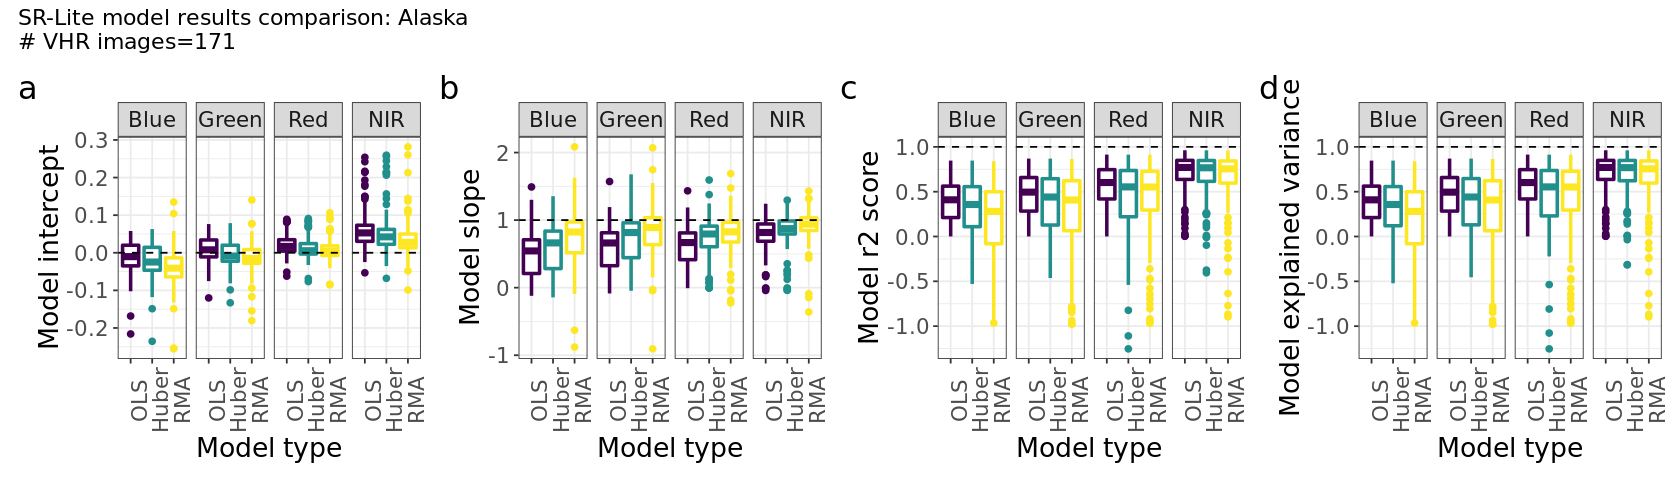

In [291]:
options(repr.plot.width = 14, repr.plot.height = 4)

make_model_stats_boxplots <- function(df_tmp, y, y_name, y_intercept){
    box_p = df_tmp %>%
        ggplot() +
        geom_boxplot(aes(y= {{ y }} , x=comparison, color=comparison), size=1, show.legend=FALSE) +
        geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_grid(. ~ band ,
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(y=y_name, x='', caption=NULL)
    }

layout = "
ABCD
"

make_model_stats_boxplots(df_tmp, intercept, 'Model intercept', y_intercept=0) + #box_slope + box_r2 +
make_model_stats_boxplots(df_tmp, slope, 'Model slope', y_intercept=1) +
make_model_stats_boxplots(df_tmp, r2_score, 'Model r2 score', y_intercept=1) +
make_model_stats_boxplots(df_tmp, explained_variance, 'Model explained variance', y_intercept=1) +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a', title=paste0('SR-Lite model results comparison: ', REGION, '\n# VHR images=', length(levels(factor(df_tmp$scene))) ) ) 

In [326]:
quantile(df_tmp.m$value, na.rm=TRUE)[2]

25% 
0.01024346

In [330]:
options(repr.plot.width = 20, repr.plot.height = 10)

library(reshape2)

stats_cols_list = c('intercept','slope','score','r2_score','explained_variance','mbe','mae','mape','medae','rmse','mean_ccdc_sr','mean_evhr_srlite','mae_norm','rmse_norm','comparison')
df_tmp.m = melt(df_tmp %>% dplyr::select(region, scene, band, all_of(stats_cols_list)), id_vars = c('region', 'scene', 'band'))

df_tmp.m %>% 
        ggplot() +
        geom_boxplot(aes(y= value , x=comparison, color=comparison), size=1, show.legend=FALSE, outlier.shape = NA) +
        #geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_wrap(band~variable , scales="free_y", ncol=length(stats_cols_list)-1
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        #scale_y_continuous(limits=c(quantile(df_tmp.m$value, na.rm=TRUE)[2] - 1.5*IQR(df_tmp.m$value, na.rm=TRUE), quantile(df_tmp.m$value, na.rm=TRUE)[4] + 1.5*IQR(df_tmp.m$value, na.rm=TRUE) )) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(x='', caption=NULL)

Using region, scene, band, comparison as id variables



ERROR: Error in quantile(value, na.rm = TRUE): object 'value' not found


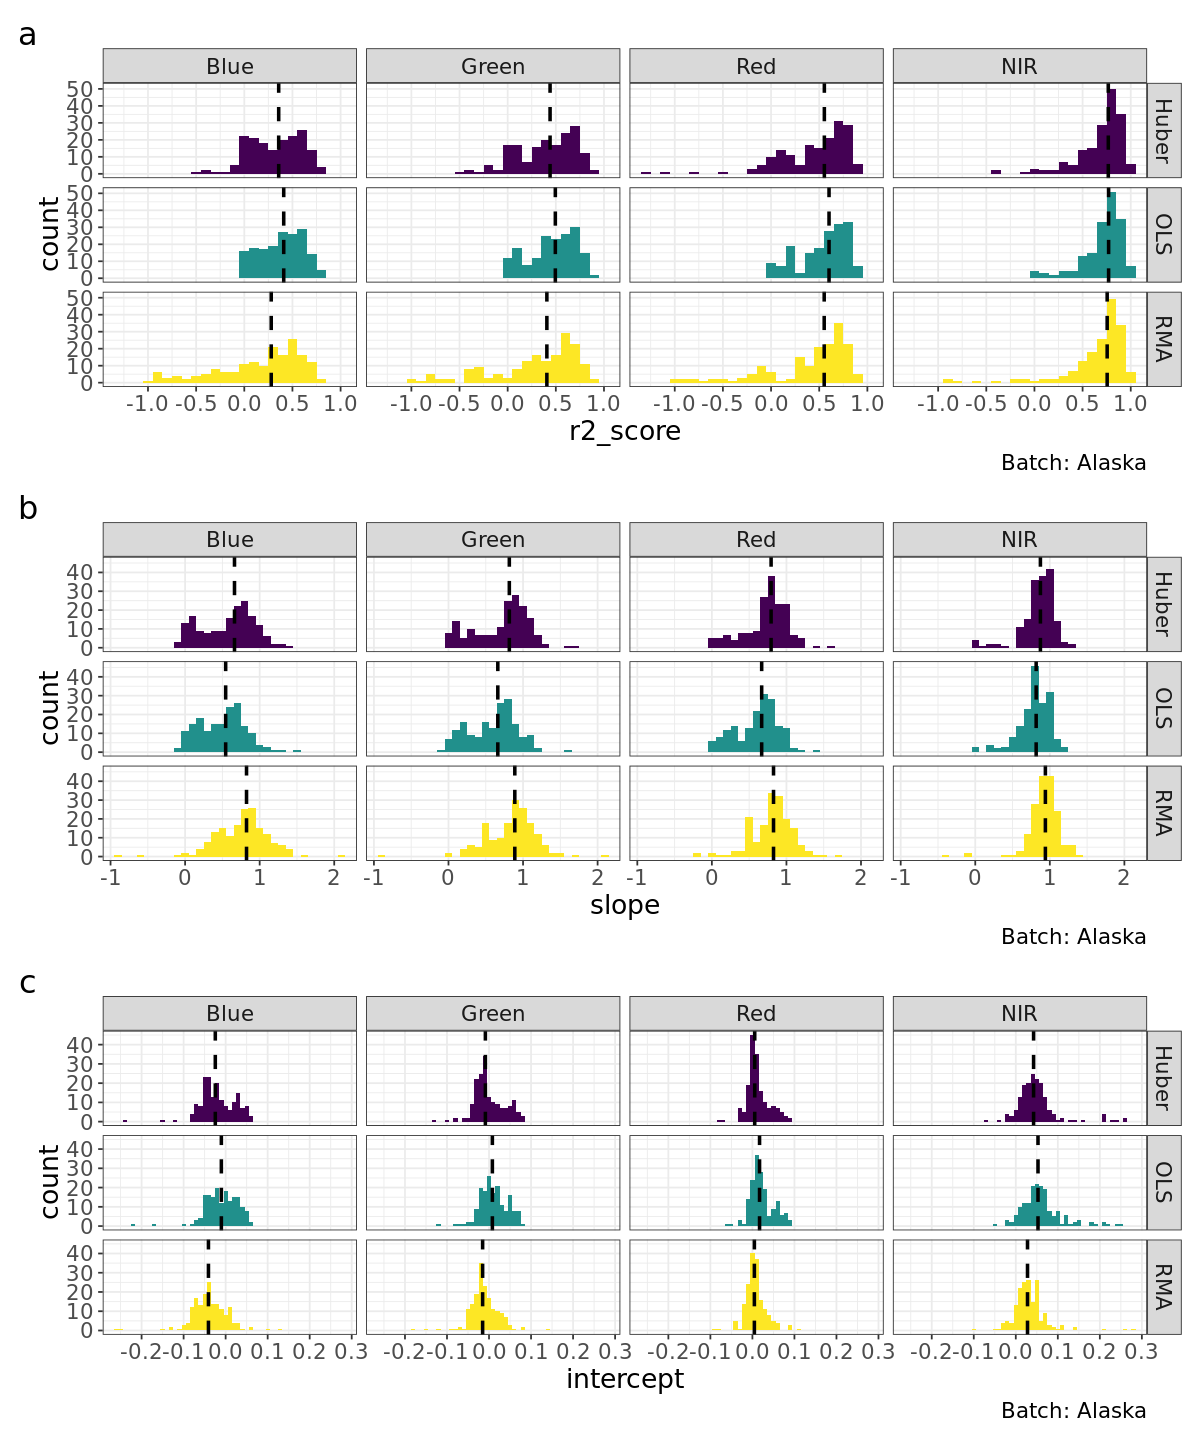

In [189]:
options(repr.plot.width = 10, repr.plot.height = 12)

layout = "
A
B
C
"

hist_r2_score + hist_slope + hist_int +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))

### Sample of reflectance from 30m pixels from the stack of SRLite output, TOA input, and CCDC input (with common mask applied)
From all batches, a sample of 0.001 of the pixels is used to compare results across all images, bands, and linear models

In [130]:
sample_reflectance_table_fn = '/explore/nobackup/people/pmontesa/srlite/srlite_diagnostics_20221028/global/global_from_sample_p001.csv'

In [134]:
reflect_df <- read_csv(sample_reflectance_table_fn) %>%
  select(file_name, everything(), -`...1`) %>%
  rename(path = file_name) %>%
  mutate(file = path_file(path),
         region = str_split_fixed(file, '_', 6)[,1],
         satellite = str_split_fixed(file, '_', 6)[,2],
         yyyymmdd = str_split_fixed(file, '_', 6)[,3],
         prod_code = str_split_fixed(file, '_', 6)[,4],
         catId = str_split_fixed(file, '_', 6)[,5])

reflectances <- tibble(ReflectanceType = c('CCDC_SR','EVHR_TOA','EVHR_SRLite','EVHR_OTF_RMA','EVHR_OTF_OLS','EVHR_OTF_Huber'))
                       # ReflectanceTypePretty = c('CCDC SR', 'EVHR TOAR', 'EVHR SRLite', 'EVHR OTF RMA SR', 'EVHR OTF OLS SR', 'EVHR OTF Huber'))
bands <- tibble(Band = c('Blue','Green','Red','NIR'),
                Band_so = c(1,2,3,4)) %>%
  mutate(Band = fct_reorder(Band, Band_so)) %>%
  select(-Band_so)

reflectances_bands <- crossing(reflectances, bands) %>%
  mutate(name = glue('{ReflectanceType}{Band}'))

reflect_df_longer <- reflect_df %>%
  pivot_longer(cols=where(is.numeric), values_to='Reflectance') %>%
  left_join(reflectances_bands) %>%
  select(-name)

reflect_df_long <- reflect_df_longer %>%
  group_by(path, ReflectanceType) %>%
  mutate(row = row_number()) %>%
  pivot_wider(names_from=ReflectanceType, values_from=Reflectance) %>%
  select(-row) %>%
  ungroup()

New names:
* `` -> ...1

Rows: 414163 Columns: 26

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): file_name
dbl (25): ...1, CCDC_SRBlue, CCDC_SRGreen, CCDC_SRRed, CCDC_SRNIR, EVHR_TOAB...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining, by = "name"



In [117]:
head(reflect_df_longer)

path,file,region,satellite,yyyymmdd,prod_code,catId,Reflectance,ReflectanceType,Band
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.4178,CCDC_SR,Blue
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.5851,CCDC_SR,Green
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.8033,CCDC_SR,Red
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.6710,CCDC_SR,NIR
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.6032,EVHR_TOA,Blue
/explore/nobackup/people/mmacande/srlite/srlite_diagnostics_20221028/csv/Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands_WV02_20150911_M1BS_1030010049148A00_sample_p001.csv,Whitesands,WV02,20150911,M1BS,1030010049148A00,0.5805,EVHR_TOA,Green


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



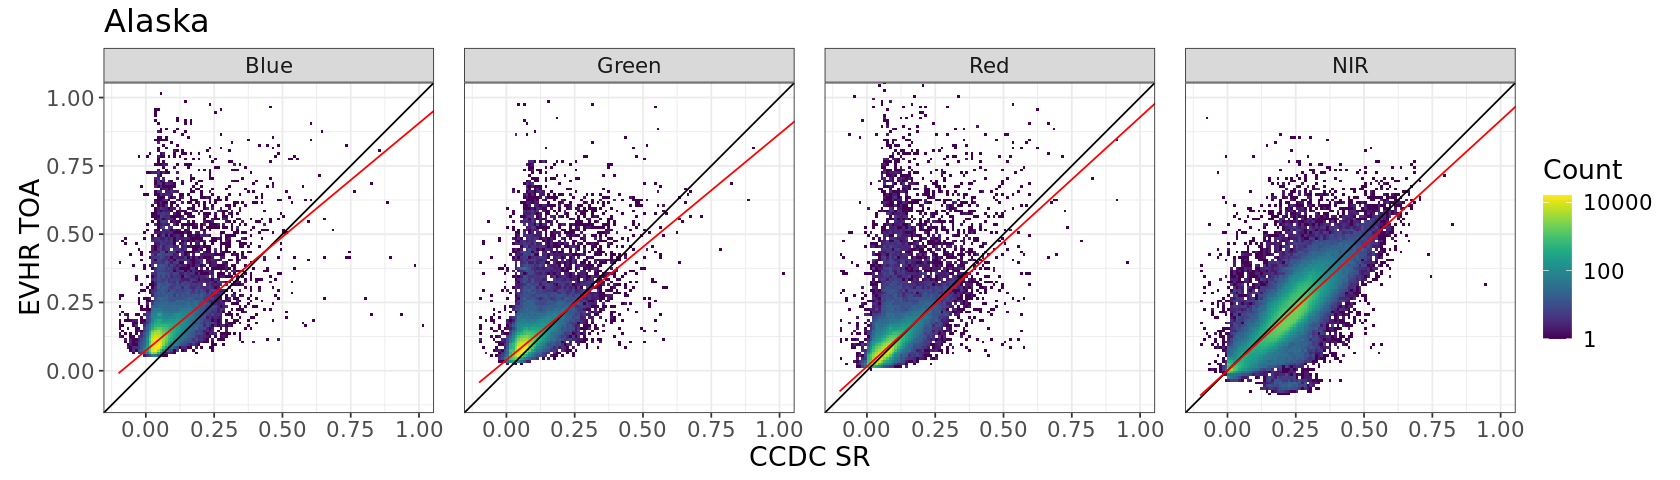

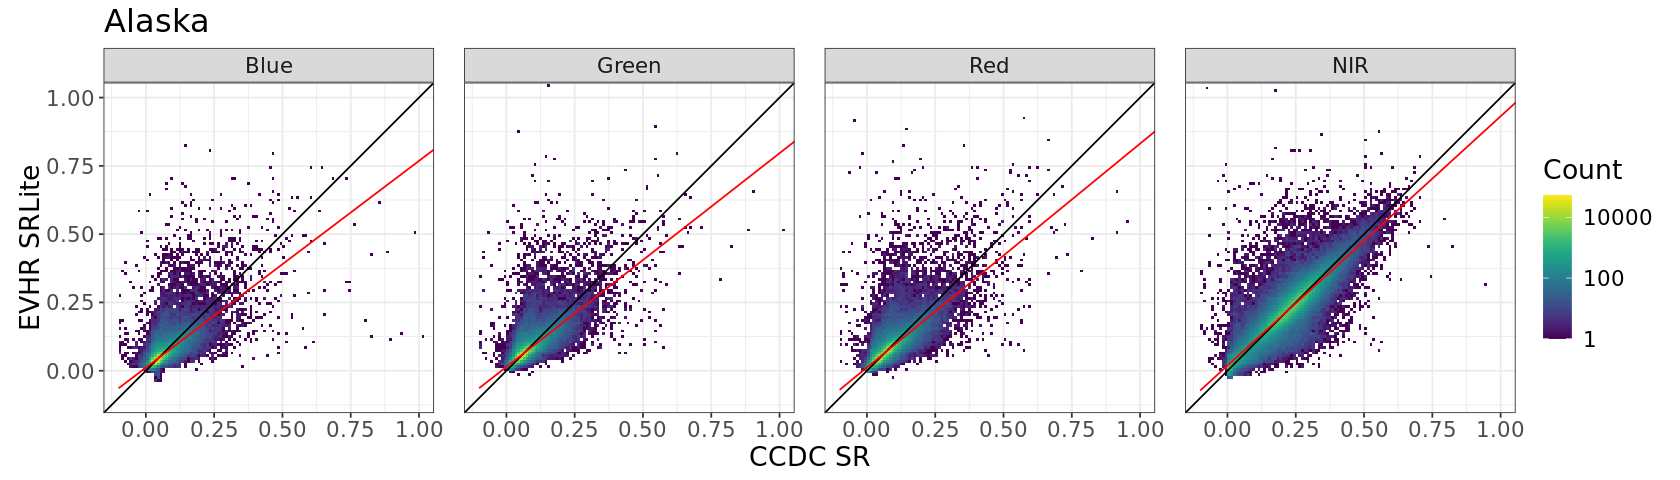

In [135]:
options(repr.plot.width = 14, repr.plot.height = 4)


reflectance_scatter <- function(data, x, y, binWidth, reflMin, reflMax, title) { #xlab, ylab, title) {
  # print(x)
  xname = select(data, {{ x }}) %>% colnames()
  yname = select(data, {{ y }}) %>% colnames()
  
  ggplot(data, aes(x={{ x }}, y={{ y }})) +
  # ggplot(data, aes(x=CCDC_SR, y=EVHR_SRLite)) +
    # coord_fixed() +
    coord_cartesian(xlim=c(reflMin,reflMax), ylim=c(reflMin,reflMax)) +
    geom_bin2d(binwidth=binWidth, color=NA) + # Geometric object to use for drawing
    # scale_fill_cmap(trans='log10', name='Count') +
    scale_fill_viridis(trans='log10', name='Count') +
    scale_color_viridis(trans='log10', name='Count') +
    geom_abline(slope = 1, intercept = 0, size=0.5)+
    geom_smooth(method = 'lm', color='red', size=0.5, se=F) +
    facet_wrap('Band', nrow=1) +#, scales='free') +
    # facet_grid(Band ~ region) +
    theme_bw() +
    theme(text = element_text(size=16),
          aspect.ratio = 1,
          panel.spacing = unit(0.25, 'inch')) +
            # subplots_adjust={'wspace': 0.25, 'hspace': 0.25}) + # add spacing between facets to make y-axis ticks visible
            # axis.text and strip.text and labs x & y 
    xlab(str_replace(xname, '_', ' ')) +
    ylab(str_replace(yname, '_', ' ')) +
    ggtitle(title) 
    
}

reflectance_scatter_by_region <- function(data, x, y, binWidth, reflMin, reflMax, region) {
  xname = select(data, {{ x }}) %>% colnames()
  yname = select(data, {{ y }}) %>% colnames()
  reflectance_scatter(data %>% filter(region == {{ region }}), {{ x }}, {{ y }}, binWidth, reflMin, reflMax, region)
  #ggsave(path(wDir, '20221028', 'plots', glue('{region}_{yname}_v_{xname}.png')), width=5, height=4, dpi=600)
}

# reflectance_scatter(reflect_df_long %>% filter(region == 'Whitesands'), CCDC_SR, EVHR_TOA, 0.002, -0.1, 1, 'Whitesands')
reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_TOA, 0.01, -0.1, 1, 'Alaska')
reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska')
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.002, -0.1, 1, 'Alaska')
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 1, 'CCDC SR', 'EVHR SRLite', 'title', 'Whitesands')

# cn = select(reflect_df_long, 'CCDC_SR') %>% colnames()
# print(cn)
# cn
# cn[1]
# class(cn)
# reflectance_scatter(reflect_df_long, CCDC_SR, EVHR_TOA, 1, 'CCDC SR', 'EVHR TOA', 'title')

`geom_smooth()` using formula 'y ~ x'



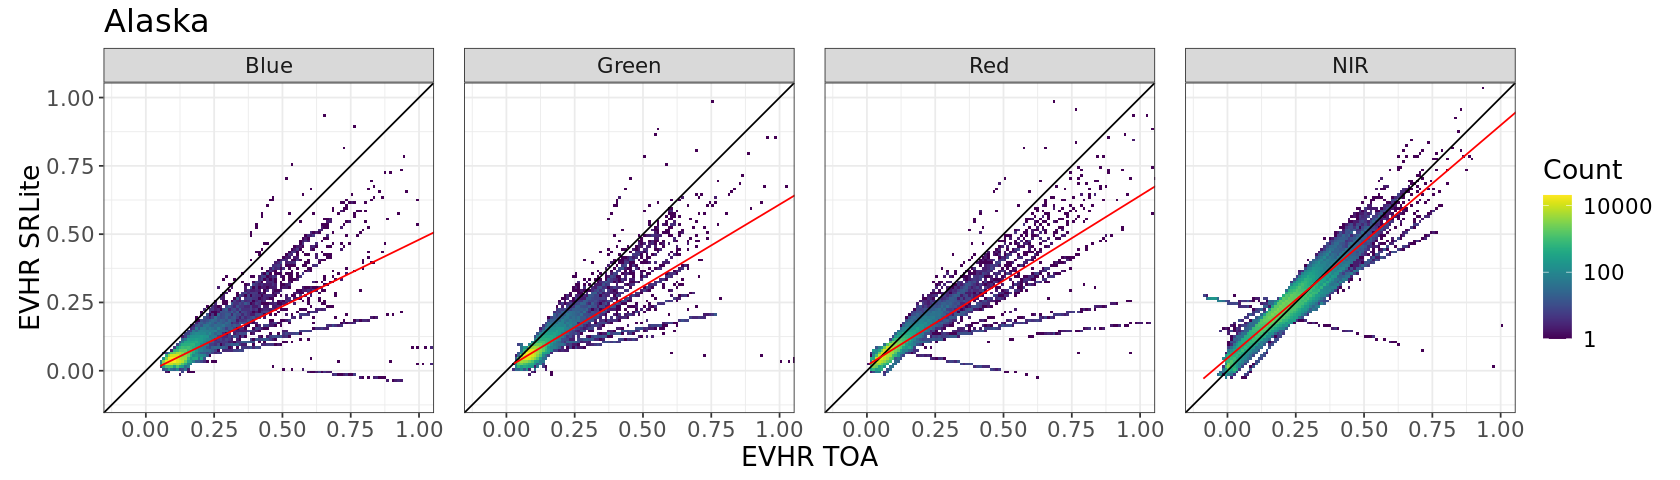

In [133]:
reflectance_scatter_by_region(reflect_df_long, EVHR_TOA, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska')